## World map with L2 difference between human preferences and gpt4 preferences

In [1]:
import matplotlib.pyplot as plt
import geopandas
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
gpt4=pd.read_csv("./cluster_data/model_preferences_by_lang_gpt4.csv")

humans=pd.read_csv("./cluster_data/human_preferences_by_country.csv")

## I modified manually the file
population=pd.read_csv("./cluster_data/proportions_population.csv")

In [3]:
gpt4=pd.melt(gpt4,id_vars='criterion',value_name='estimate',var_name='Languages')

In [4]:
country_lang=population.merge(gpt4,on=['Languages'])

country_lang['weighted_estimate']=(country_lang.percentage*country_lang.estimate)/100

country_lang=country_lang.groupby(['Country','ISO3','criterion']).agg({'weighted_estimate':np.sum}).reset_index()

In [5]:
humans=humans.rename(columns={'Country':'ISO3','Label':'criterion','Estimates':'human_estimate'})

humans=humans.loc[humans.criterion.isin(['Gender', 'Fitness',
       'Social Status', 'Age', 'No. Characters', 'Species'])]

In [6]:
map_rep={'Gender':'Gender_Female', 'Fitness':'Fitness_Fit',
       'Social Status':'SocialValue_High', 'Age':'Age_Young', 'No. Characters':'Utilitarianism_More', 'Species':'Species_Humans'}

In [7]:
humans.criterion=humans.criterion.replace(map_rep)

In [8]:
humans_gpt=humans.merge(country_lang,on=['ISO3','criterion'])

In [9]:
humans_gpt.human_estimate=humans_gpt.human_estimate*100

humans_gpt['sqe']=(((humans_gpt.weighted_estimate/1)-(humans_gpt.human_estimate/1))**2)

In [10]:
df_agg=humans_gpt.groupby(['Country','ISO3']).agg({'sqe':np.sum}).reset_index()

In [11]:
population=population.loc[:,['ISO3','Value']].drop_duplicates()

In [12]:
df_agg=df_agg.merge(population,on='ISO3')

In [13]:
df_agg['sqe']=df_agg['sqe']**0.5

In [14]:
df_agg

,Country,ISO3,sqe,Value
0,Afghanistan,AFG,134.062993,40099462.0
1,Albania,ALB,112.518249,2811666.0
2,Algeria,DZA,119.767031,44177969.0
3,Andorra,AND,68.105802,79034.0
4,Angola,AGO,118.550762,34503774.0
...,...,...,...,...
146,Uzbekistan,UZB,101.173847,34915100.0
147,Venezuela,VEN,101.480697,28199867.0
148,Vietnam,VNM,135.450558,97468029.0
149,Zambia,ZMB,115.497206,19473125.0


In [15]:
df_agg.sqe.describe()

count    151.000000
mean     107.482042
std       23.052418
min       28.838093
25%       98.647458
50%      109.497641
75%      120.681161
max      160.596646
Name: sqe, dtype: float64

In [16]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world=world.loc[world.continent!='Antarctica',:]

/tmp/ipykernel_6281/3620744348.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


world.loc[~world.iso_a3.isin(df_agg.ISO3.unique())]

df_agg.loc[~df_agg.ISO3.isin(world.iso_a3.unique())]

In [17]:
df_agg=df_agg.loc[df_agg.ISO3.isin(world.iso_a3.unique())].reset_index(drop=True)

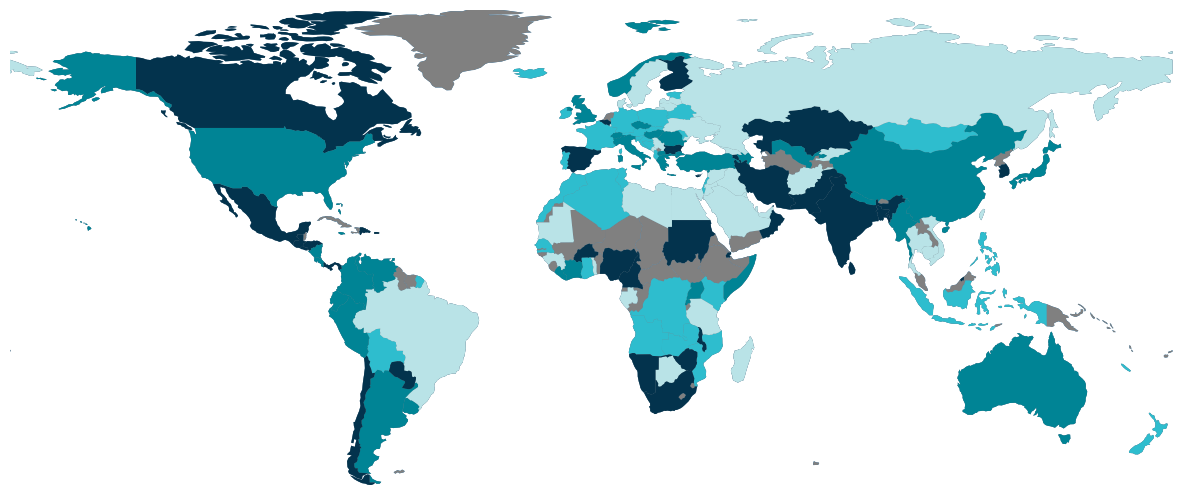

In [18]:



ax = world.plot(figsize=(15, 9))
world.plot(color='gray',edgecolor='none',ax=ax)
for i,d in df_agg.iterrows():
    if d['sqe']<=df_agg.sqe.quantile(0.25):
        world[world.iso_a3 == d['ISO3']].plot(color='#03334D',ax=ax)
    elif (d['sqe']<=df_agg.sqe.quantile(0.5)) and (d['sqe']>df_agg.sqe.quantile(0.25)):
        world[world.iso_a3 == d['ISO3']].plot(color='#008495',ax=ax)
    elif (d['sqe']<=df_agg.sqe.quantile(0.75)) and (d['sqe']>df_agg.sqe.quantile(0.5)):
        world[world.iso_a3 == d['ISO3']].plot(color='#2EBDCE',ax=ax)
    elif  (d['sqe']>df_agg.sqe.quantile(0.75)):
        world[world.iso_a3 == d['ISO3']].plot(color='#B9E3E7',ax=ax)
plt.xticks([])
plt.yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.margins(0)
plt.savefig('./cluster_data/fig_map_l2.pdf',dpi=300,bbox_inches='tight')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


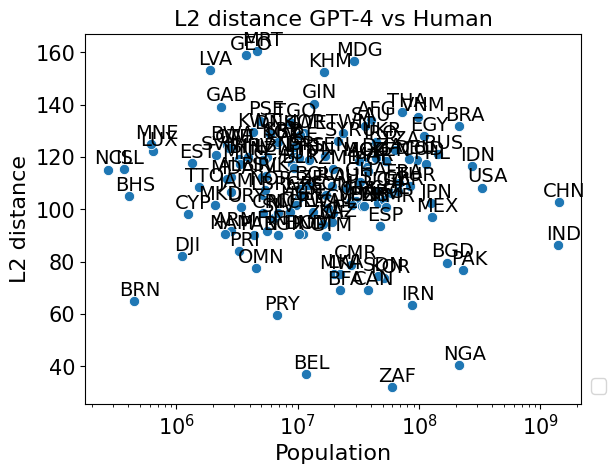

In [19]:
ax=sns.scatterplot(data=df_agg,x='Value',y='sqe',s=55)
#plt.yscale('log')
plt.xscale('log')
plt.title('L2 distance GPT-4 vs Human',size=16)
plt.ylabel('L2 distance',size=16)
plt.xlabel('Population',size=16)
#lgd=sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
lgd = ax.legend(loc=3, bbox_to_anchor=(1,0),fontsize=14)
for i in range(df_agg.shape[0]):
    plt.annotate(df_agg.ISO3.values[i], (df_agg['Value'].values[i], df_agg.sqe.values[i]), textcoords="offset points", xytext=(4,4), ha='center',fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
#plt.savefig('mse_scatter2_log.png', transparent=True,bbox_extra_artists=(lgd,),bbox_inches='tight')

plt.savefig('./cluster_data/fig_scatter_l2.pdf',dpi=300,bbox_extra_artists=(lgd,),bbox_inches='tight')